# PROJECT: Positive and Negative Sentiment Analysis of Bengali Texts

This project aims to perform sentiment analysis of Bengali texts. The [dataset](https://data.mendeley.com/datasets/p6zc7krs37/4) used in this analysis consists of positive and negative reviews collected from Youtube Bengali drama $^{1}$. 

The model is formulated as a binary classification problem using GRU network and CrossEntropyLoss function. In order to avoid the imbalance of the dataset, equal number of positive and negative reviews are taken as the training set. The model is trained on 270 sentences only due to limitation of the computational resources and to speed up the training process. It is also observed whether a small training set will be sufficient for the model to generalize above chance on the unseen test set. 

Approximately 74\% of the test set of 1020 samples is correctly classified by the trained model. It is possible that better generalization ability of the model can be achieved with larger training set with higher variance. It is important to note here that the model's performance significantly depends on the nature of the training set as in some of the trial runs with a different training set (generated by random shuffle and choice) the model failed to produce any meaningful predictions. Both early stopping and learning rate scheduler are implemented to track the overfitting of the model.

In [ ]:
import numpy as np
import re
import random
import multiprocessing as mp
import matplotlib.pyplot as plt

import torch
from collections import OrderedDict

In [ ]:
# Create sentiment classification model. RNN, LSTM, GRU - any of these algorithms can be experimented. 

class SentimentAnalysis():
    def __init__(self, seq_len, vocab_size, embed_dim, numOut, algo='gru', hidden_size = 10, hidden_layers = 1, batch_first = True, bidirectional = False):
        self.timesteps = seq_len
        self.numHidden = hidden_size
        self.numLayers = hidden_layers
        self.direction = 1+int(bidirectional)
        self.algo = algo
        
        self.embedding = torch.nn.Embedding(vocab_size+1, embed_dim, padding_idx = 0)
          
        algo_dict = {'rnn': torch.nn.RNN(input_size = embed_dim, 
                                         hidden_size = self.numHidden, 
                                         num_layers = self.numLayers, 
                                         batch_first = batch_first, 
                                         dropout = 0.2,
                                         bidirectional = bidirectional),
                    'lstm': torch.nn.LSTM(input_size = embed_dim, 
                                          hidden_size = self.numHidden, 
                                          num_layers = self.numLayers, 
                                          batch_first = batch_first, 
                                          dropout = 0.2,
                                          bidirectional = bidirectional),
                    'gru': torch.nn.GRU(input_size = embed_dim, 
                                        hidden_size = self.numHidden, 
                                        num_layers = self.numLayers, 
                                        batch_first = batch_first, 
                                        dropout = 0.2,
                                        bidirectional = bidirectional)}

        self.rnn_net = algo_dict[algo]
        
        self.relu = torch.nn.ReLU()
        self.fc_layer = torch.nn.Linear(self.numHidden*self.direction, 5)
        self.fc_relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)
        self.output_layer = torch.nn.Linear(5, numOut)
        
        self.neunet = torch.nn.Sequential(OrderedDict([('embedding_layer', self.embedding),
                                                       ('rnnnet_layer', self.rnn_net), 
                                                       ('relu_layer', self.relu), 
                                                       ('fc_layer', self.fc_layer),
                                                       ('fc_relu_layer', self.fc_relu),
                                                       ('dropout_layer', self.dropout),
                                                       ('out_layer', self.output_layer)]))
        self.error_trace = []
        self.error_trace_valid = []
        
    def train(self, XT, XTvalid, device, cpu_count, batch_size = None, learning_rate = 0.02, n_epochs = 200, early_stop_patience = 100):
        n_patience = 0
        best_error_diff = None
        if batch_size is None:
              batch_size = len(XT)
        trainloader = torch.utils.data.DataLoader(XT, batch_size = batch_size, num_workers = cpu_count, shuffle = True)
        validloader = torch.utils.data.DataLoader(XTvalid, batch_size = batch_size, num_workers = cpu_count, shuffle = False)
        lossFunc = torch.nn.CrossEntropyLoss()
        weight_decay = 1e-1
        clip_norm = 5
        optimizer = torch.optim.Adam(self.neunet.parameters(), lr = learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)
        self.neunet.to(device)
        self.neunet.train()
        for epoch in range(n_epochs):
            epoch_error = []
            epoch_error_valid = []
            for valid_batch in validloader:
                Xv, Tv = valid_batch
                Xv = Xv.to(device)
                Tv = Tv.to(device)
                Yvalid = self.test(Xv, device)
                error_valid = lossFunc(Yvalid, Tv.long())
                epoch_error_valid.append(error_valid.item())
            if epoch % 10 == 9:
                self.print_accuracy(Yvalid, Tv, 'Validation')
            validation_error = np.array(epoch_error_valid).mean()
            self.error_trace_valid.append(validation_error)
            if best_error_diff is None:
                best_error_diff = validation_error
            elif best_error_diff < validation_error:
                n_patience += 1
                if n_patience == early_stop_patience:
                    break
            else:
                best_error_diff = validation_error
                n_patience = 0

            for batch in trainloader:
                X, T = batch
                X = X.to(device)
                T = T.to(device)
                Y_pred = self.forward(X.long(), device) 
                optimizer.zero_grad()
                error = lossFunc(Y_pred, T.long())
                error.backward()
                optimizer.step()
                epoch_error.append(error.item())
            self.error_trace.append(np.array(epoch_error).mean())
            if epoch % 10 == 9:
                print(f'Epoch: {epoch + 1} | Error: {self.error_trace[-1]:.3f}')
                Ytrain = self.test(X, device)
                self.print_accuracy(Ytrain, T, 'Training')
                
    def forward(self, X, device):
        n_samples = X.shape[0]
        X = self.neunet.embedding_layer(X)
        hidden_out, _ = self.neunet.rnnnet_layer(X)
        hidden_final = torch.cat((hidden_out[:, -1, :self.numHidden], hidden_out[:, 0, self.numHidden:]), dim = 1)
        out = self.neunet[2:](hidden_final) 
        Y = out 
        return Y
    
    def test(self, X, device):
        with torch.no_grad():
            Y = self.forward(X.long(), device)
        return Y

    def print_accuracy(self, Y, T, data_set):
        Y = torch.nn.functional.softmax(Y, dim = 1)
        Y = Y.detach()
        correct = torch.where(torch.argmax(Y, dim=1).reshape(-1) == T.reshape(-1))[0]
        print(f'{data_set} set | Accuracy: {len(correct) / T.shape[0]}')

    def get_error_trace(self):
        return self.error_trace, self.error_trace_valid

In [ ]:
# Load dataset

class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, datalist, word2idx, seq_length):
        self.datalist = datalist
        self.word2idx = word2idx
        self.seq_length = seq_length

    def __len__(self):
        return len(self.datalist)
  
    def __getitem__(self, index):
        seq, label = self.datalist[index]
        seq_vector = np.array([self.word2idx.get(word, 0) for word in seq.split(' ')])
        seq_transformed = self.transform(seq_vector)
        return seq_transformed, int(label)

    def transform(self, seq_vector):
        seq_transformed = np.zeros(self.seq_length)
        seq_transformed[:len(seq_vector)] = seq_vector
        return seq_transformed

In [ ]:
# Create training, validation, and test set

neg_path = '/content/all_negative_3307.txt'
pos_path = '/content/all_positive_8500.txt'

punc_list = ['।', '?', '!', ',', ';', '\'', '\"', '/', ':', '(', ')', '{', '}', '[', ']', '.', '*', '-', '_', '+', '=', '%']

with open(neg_path) as f:
    neglines = f.read().split('\n')

with open(pos_path) as f:
    poslines = f.read().split('\n')

neglines_spaced = [''.join([c if c not in punc_list else ' '+c for c in line.strip()]) for line in neglines[:-1]]
poslines_spaced = [''.join([c if c not in punc_list else ' '+c for c in line.strip()]) for line in poslines[:-1]]

# Sentences with number of words less than 20 are taken for simplify the problem domain
# Negative sentiment is labeled as 0 and positive sentiment is labeled as 1

negset = [(re.sub('\s+', ' ', line), 0) for line in neglines_spaced if len(line) < 20]
posset = [(re.sub('\s+', ' ', line), 1) for line in poslines_spaced if len(line) < 20]

# Number of training samples are significantly reduced (only 20%)

n_train = int(len(negset)*0.2)
n_test = int(len(negset)*0.05)
train_set = negset[:n_train] + posset[:n_train]
valid_set = negset[n_train:n_train+n_test] + posset[n_train:n_train+n_test]
test_set = negset[n_train+n_test:] + posset[n_train+n_test:len(negset)]

# Randomly shuffle all the samples in the training, validation, and test set

random.shuffle(train_set)
random.shuffle(valid_set)
random.shuffle(test_set)
print(f'Training n_samples: {len(train_set)}')
print(f'Validation n_samples: {len(valid_set)}')
print(f'Test n_samples: {len(test_set)}')

Training n_samples: 270
Validation n_samples: 66
Test n_samples: 1020


In [ ]:
# Create word to index dictionary and vice versa, 
# get vocab size and longest sequence length, 
# define number of target classes (sentiments to be predicted)

dataset = negset + posset
vocabs = list(set([word for line in dataset for word in line[0].split(' ')]))
word2idx = {w: i for i, w in enumerate(vocabs, start = 1)}
idx2word = {v: k for k, v in word2idx.items()}
vocab_size = len(vocabs)
seq_length_train = max([len(line[0]) for line in train_set])
seq_length_valid = max([len(line[0]) for line in valid_set])
seq_length_test = max([len(line[0]) for line in test_set])
n_classes = len(list(set([line[1] for line in train_set])))

In [ ]:
batch_size = None
cpu_count = mp.cpu_count()
print(f'cpu count: {cpu_count}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = max(seq_length_train, seq_length_valid, seq_length_test)

trainset = LoadDataset(train_set, word2idx, seq_length_train)
validset = LoadDataset(valid_set, word2idx, seq_length_valid)
testset = LoadDataset(test_set, word2idx, seq_length_test)

cpu count: 2


In [ ]:
# Train the model. 

train_data = trainset
n_seq = seq_len
n_embed = 200
sentnet = SentimentAnalysis(n_seq, vocab_size, n_embed, n_classes, algo='gru', hidden_size = 100, hidden_layers = 2, bidirectional = True)
sentnet.train(train_data, validset, device, cpu_count, batch_size = None, learning_rate = 0.001, n_epochs = 400)

Validation set | Accuracy: 0.5
Epoch: 10 | Error: 0.681
Training set | Accuracy: 0.5
Validation set | Accuracy: 0.5
Epoch: 20 | Error: 0.669
Training set | Accuracy: 0.5
Validation set | Accuracy: 0.5
Epoch: 30 | Error: 0.655
Training set | Accuracy: 0.5111111111111111
Validation set | Accuracy: 0.6060606060606061
Epoch: 40 | Error: 0.637
Training set | Accuracy: 0.7296296296296296
Validation set | Accuracy: 0.7272727272727273
Epoch: 50 | Error: 0.618
Training set | Accuracy: 0.774074074074074
Validation set | Accuracy: 0.696969696969697
Epoch: 60 | Error: 0.591
Training set | Accuracy: 0.8666666666666667
Validation set | Accuracy: 0.7878787878787878
Epoch: 70 | Error: 0.565
Training set | Accuracy: 0.8851851851851852
Validation set | Accuracy: 0.7575757575757576
Epoch: 80 | Error: 0.512
Training set | Accuracy: 0.8777777777777778
Validation set | Accuracy: 0.7575757575757576
Epoch: 90 | Error: 0.475
Training set | Accuracy: 0.9148148148148149
Validation set | Accuracy: 0.8181818181818

In [ ]:
# See model's performance on the unseen test set

testloader = torch.utils.data.DataLoader(testset, batch_size = len(test_set), num_workers = 1, shuffle = False)
for X, T in testloader:        
  Ytest = sentnet.test(X.to(device), device)
sentnet.print_accuracy(Ytest, T.to(device), 'Test')

Test set | Accuracy: 0.7421568627450981


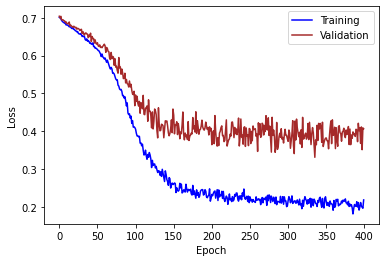

In [ ]:
# Training and Validation Error plot

plt.plot(sentnet.get_error_trace()[0], color = 'b', label = 'Training')
plt.plot(sentnet.get_error_trace()[1], color = 'brown', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Although validation loss is still on the decreasing trend, the model seems to have learned the training samples fairly quickly. However, the overfitting is obvious and that might be brought down by increasing the variance and the number of samples in the training set. 

In [ ]:
# Number of samples correctly and wrongly classified in the test set

preds = torch.argmax(Ytest, dim = 1).numpy()
Xt = [line[0] for line in test_set]
Tt = np.array([line[1] for line in test_set])
correct_idx = np.where(preds == Tt)[0]
incorrect_idx = np.where(preds != Tt)[0]
print(f'{correct_idx.shape[0]} samples correctly classified.')
print(f'{incorrect_idx.shape[0]} samples wrongly classified.')

757 samples correctly classified.
263 samples wrongly classified.


In [ ]:
# Lets take a look at some of the samples correctly and wrongly being classified

sentiment_code = {0: 'Neg', 1: 'Pos'}
print('Correctly classified:\n')
for ic in correct_idx[:10]:
    print(f'{Xt[ic]} | prediction: {sentiment_code[preds[ic]]} | actual: {sentiment_code[Tt[ic]]}')
print('\n')
print('Wrongly classified:\n')
for ic in incorrect_idx[20:30]:
    print(f'{Xt[ic]} | prediction: {sentiment_code[preds[ic]]} | actual: {sentiment_code[Tt[ic]]}')

Correctly classified:

নাটকটা অসাধারণ ছিল | prediction: Pos | actual: Pos
আমার খুব ভালো লাগলো | prediction: Pos | actual: Pos
খুব ভালো লাগলো | prediction: Pos | actual: Pos
ফালতু নাটক | prediction: Neg | actual: Neg
ভালোই লাগছে নাটক | prediction: Pos | actual: Pos
বেস্ট অফ নাটক | prediction: Pos | actual: Pos
অসাধারণ , , , | prediction: Pos | actual: Pos
ফালতু নাটক একটা । | prediction: Neg | actual: Neg
আবাল মার্কা নাটক | prediction: Neg | actual: Neg
হেরার নাটক । | prediction: Neg | actual: Neg


Wrongly classified:

এটা কোন কাহিনী হল । | prediction: Pos | actual: Neg
তেমন ভালো লাগল না । | prediction: Pos | actual: Neg
ফাল্তু একটা নাটক | prediction: Pos | actual: Neg
টাইম নষ্ট | prediction: Pos | actual: Neg
ফাওল একটা নাটক | prediction: Pos | actual: Neg
অস্থির একটা নাটক | prediction: Pos | actual: Neg
সুন্দর লাগে নাটক টা | prediction: Neg | actual: Pos
এরকম হয় নাকি ? ? ? | prediction: Pos | actual: Neg
এসব মেয়ে অনেক খারাপ | prediction: Pos | actual: Neg
বোকা নির্বোধ | prediction: P

Note: Many of the sentences are repeated (or closely resemble) in the dataset. It should be possible to generate higher performing model by cleaning the duplicate samples.

# References:

1. Sazzed, Salim (2021), “Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus”, Mendeley Data, V4, doi: 10.17632/p6zc7krs37.4

